# Test Loss Functions on Multiple Models

In [1]:
import sys
sys.path.append('src')
import pandas as pd
import numpy as np
import xgboost as xg
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import yaml
import matplotlib.pyplot as plt
# Local modules
from data_funcs import train_test_split_spacetime
from fmda_models import LM, XGB, RF
from metrics import ros, rmse
import reproducibility

## Read Data

In [2]:
df = pd.read_pickle("data/raws_df.pkl")
df = df.dropna()
df.columns

Index(['Ew', 'Ed', 'temp', 'rh', 'rain', 'precip_accum', 'fm', 'wind', 'solar',
       'time_raws', 'STID', 'lat', 'lon', 'elev', 'hour', 'doy', 'date'],
      dtype='object')

In [3]:
df

,Ew,Ed,temp,rh,rain,precip_accum,fm,wind,solar,time_raws,STID,lat,lon,elev,hour,doy,date
2023-05-17 03:09:00,13.147834,14.552503,284.817,48.0,0.00,470.408,7.5,1.790,1.0,2023-05-17 03:09:00,CPTC2,38.45944,-109.04694,8088,3,137,2023-05-17 03:09:00
2023-05-17 04:09:00,13.247513,14.652182,284.261,48.0,0.00,470.408,8.1,1.790,0.0,2023-05-17 04:09:00,CPTC2,38.45944,-109.04694,8088,4,137,2023-05-17 04:09:00
2023-05-17 05:09:00,12.876054,14.274707,284.261,46.0,0.00,470.408,8.6,1.790,0.0,2023-05-17 05:09:00,CPTC2,38.45944,-109.04694,8088,5,137,2023-05-17 05:09:00
2023-05-17 06:09:00,13.446692,14.851361,283.150,48.0,0.00,470.408,9.2,1.790,0.0,2023-05-17 06:09:00,CPTC2,38.45944,-109.04694,8088,6,137,2023-05-17 06:09:00
2023-05-17 07:09:00,14.000874,15.412836,283.150,51.0,0.00,470.408,9.6,1.790,0.0,2023-05-17 07:09:00,CPTC2,38.45944,-109.04694,8088,7,137,2023-05-17 07:09:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-14 19:17:00,5.988904,7.156126,293.706,20.0,0.00,6.096,9.4,1.343,970.0,2024-05-14 19:17:00,TT815,37.52272,-108.48178,7576,19,135,2024-05-14 19:17:00
2024-05-14 20:17:00,9.688784,11.031949,290.372,35.0,0.00,6.096,7.3,0.448,426.0,2024-05-14 20:17:00,TT815,37.52272,-108.48178,7576,20,135,2024-05-14 20:17:00
2024-05-14 21:17:00,11.794500,13.189754,289.261,45.0,5.08,11.176,8.0,1.343,594.0,2024-05-14 21:17:00,TT815,37.52272,-108.48178,7576,21,135,2024-05-14 21:17:00
2024-05-14 22:17:00,7.987530,9.267817,292.039,28.0,0.00,11.176,8.0,1.790,742.0,2024-05-14 22:17:00,TT815,37.52272,-108.48178,7576,22,135,2024-05-14 22:17:00


## Setup Models

In [4]:
with open('models/params.yaml', 'r') as file:
    params = yaml.safe_load(file)

params

{'xgb': {'max_depth': 3,
  'eta': 0.1,
  'min_child_weight': 1,
  'subsample': 0.8,
  'colsample_bytree': 0.9,
  'scale_pos_weight': 1,
  'n_estimators': 100,
  'gamma': 0.1},
 'rf': {'n_estimators': 25,
  'criterion': 'squared_error',
  'max_depth': 5,
  'min_samples_split': 2,
  'min_samples_leaf': 1,
  'max_features': 0.8,
  'bootstrap': True,
  'max_samples': None,
  'random_state': None,
  'verbose': 0,
  'warm_start': False},
 'mlp': {'hidden_units': 10,
  'activation': 'relu',
  'optimizer': 'adam',
  'epochs': 10,
  'batch_size': 32,
  'validation_split': 0.2,
  'dropout': 0.2,
  'learning_rate': 0.001},
 'lm': {'fit_intercept': True}}

In [5]:
def initialize_models():
    models = {
        'xgb' : XGB(params['xgb']),
        'lm' : LM(params['lm']),
        'rf' : RF(params['rf'])
    }

    return models

models = initialize_models()

In [6]:
def create_exp_function(w):
    def exp_function(y_train):
        return tf.exp(tf.multiply(-w, y_train))
    return exp_function

## Function test:
# fun = create_exp_function(.05)
# fun(y_train = np.array([1,2,3]))

In [7]:
def loss_setup(ws = None):
    loss_fucs = ["rss", "exp", "ros"]
    # set up return dictionary
    loss = {
        'rss' : {
            'w_func' : None
        }
    } 
    # Using input omega parameter list, add dictionary key for exponential weighting for each omega in list 
    if ws is not None:
        for w in ws:
            assert isinstance(w, float) # Check that given list of floats
            dname = f"exp_{w}" # create name of dictionary key
            loss[dname] = {
                'w_func' : create_exp_function(w)
            }
    loss["ros"] = {'w_func': ros}
    return loss

In [8]:
weight_grid=np.round(np.linspace(0.01, .25, 10), 4)
print(f"Grid of Omega Weights: {weight_grid}")
loss_dict = loss_setup(ws=weight_grid)
loss_dict

Grid of Omega Weights: [0.01   0.0367 0.0633 0.09   0.1167 0.1433 0.17   0.1967 0.2233 0.25  ]


{'rss': {'w_func': None},
 'exp_0.01': {'w_func': <function __main__.create_exp_function.<locals>.exp_function(y_train)>},
 'exp_0.0367': {'w_func': <function __main__.create_exp_function.<locals>.exp_function(y_train)>},
 'exp_0.0633': {'w_func': <function __main__.create_exp_function.<locals>.exp_function(y_train)>},
 'exp_0.09': {'w_func': <function __main__.create_exp_function.<locals>.exp_function(y_train)>},
 'exp_0.1167': {'w_func': <function __main__.create_exp_function.<locals>.exp_function(y_train)>},
 'exp_0.1433': {'w_func': <function __main__.create_exp_function.<locals>.exp_function(y_train)>},
 'exp_0.17': {'w_func': <function __main__.create_exp_function.<locals>.exp_function(y_train)>},
 'exp_0.1967': {'w_func': <function __main__.create_exp_function.<locals>.exp_function(y_train)>},
 'exp_0.2233': {'w_func': <function __main__.create_exp_function.<locals>.exp_function(y_train)>},
 'exp_0.25': {'w_func': <function __main__.create_exp_function.<locals>.exp_function(y_tr

## Run Analysis

In [9]:
## COLUMNS SUBSET
cols = ["Ed", "rain", "wind", "solar", "hour", "doy", "lat", "lon"]

# Get unique month and year combos in the data
month_year = df.index.to_period('M').unique()
print(month_year)

reproducibility.set_seed(42)

# for my in month_year:
#     print("~"*50)
#     month = my.month
#     year = my.year
#     print(f"Splitting data for month: {my}")
#     df_temp = df[(df.index.month == month) & (df.index.year == year)]
#     print(f"Total observations: {df_temp.shape}")
#     X_train, X_test, y_train, y_test = train_test_split_spacetime(
#         df_temp, 
#         test_days = 2,
#         spatial_test_frac = 0.2,
#         verbose = True
#     )
#     X_train = X_train[cols]
#     X_test = X_test[cols]

my = month_year[1]
month = my.month
year = my.year
print(f"Splitting data for month: {my}")
df_temp = df[(df.index.month == month) & (df.index.year == year)]
print(f"Total observations: {df_temp.shape}")
X_train, X_test, y_train, y_test = train_test_split_spacetime(
    df_temp, 
    test_days = 2,
    spatial_test_frac = 0.2,
    verbose = True
)
X_train = X_train[cols]
X_test = X_test[cols]

PeriodIndex(['2023-05', '2023-06', '2023-07', '2023-08', '2023-09', '2023-10',
             '2023-11', '2023-12', '2024-01', '2024-02', '2024-03', '2024-04',
             '2024-05'],
            dtype='period[M]')
resetting random seeds to 42
Splitting data for month: 2023-06
Total observations: (73724, 17)
Number of Training Observations: 54410
Number of Training Locations: 85
Number of Features: 16
Time range Train: ('2023-06-01 00:03:00', '2023-06-28 23:58:00')
----------
Number of Test Observations: 1054
Number of Test Locations: 22
Time range Test: ('2023-06-29 00:06:00', '2023-06-30 23:58:00')


For each loss function and each model, we will collect 2 arrays of errors on the test set. One for the RMSE on the test fuel moisture observations, and another one on the RMSE for the same observations transformed to ROS.

In [10]:
for l in loss_dict:
    loss_dict[l][f"errs"]={}
    for mod in models:
        loss_dict[l][f"errs"][mod] = {
            "rmse_test" : [],
            "rmse_test_ROS" : []
        }

In [11]:
# Get unique month and year combos in the data
month_year = df.index.to_period('M').unique()
print(month_year)
reproducibility.set_seed(42)
for my in month_year:
    print("~"*80)
    month = my.month
    year = my.year
    print(f"Splitting data for month: {my}")
    df_temp = df[(df.index.month == month) & (df.index.year == year)]
    print(f"Total observations: {df_temp.shape}")
    X_train, X_test, y_train, y_test = train_test_split_spacetime(
        df_temp, 
        test_days = 2,
        spatial_test_frac = 0.2,
        verbose = True
    )
    X_train = X_train[cols]
    X_test = X_test[cols]
    for l in loss_dict:
        print("~"*50)
        print(f"Running models for loss func: {l}")
        if loss_dict[l]['w_func'] is not None:
            weights = loss_dict[l]['w_func'](y_train)
        else:
            weights = None
        # Reinitialize models dictionary to prevent multiple fitting iterations
        # if True:
        #     models = initialize_models()
        for mod in models:
            print(f"Fitting {mod}")
            models[mod].fit(X_train, y_train, weights)
            preds = models[mod].predict(X_test)
            loss_dict[l][f"errs"][mod]["rmse_test"].append(rmse(preds, y_test))
            loss_dict[l][f"errs"][mod]["rmse_test_ROS"].append(rmse(ros(preds), ros(y_test)))
            print(f"Test RMSE for {mod}: {rmse(preds, y_test)}")
            print(f"Test ROS RMSE for {mod}: {rmse(ros(preds), ros(y_test))}")

PeriodIndex(['2023-05', '2023-06', '2023-07', '2023-08', '2023-09', '2023-10',
             '2023-11', '2023-12', '2024-01', '2024-02', '2024-03', '2024-04',
             '2024-05'],
            dtype='period[M]')
resetting random seeds to 42
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Splitting data for month: 2023-05
Total observations: (35613, 17)
Number of Training Observations: 24622
Number of Training Locations: 83
Number of Features: 16
Time range Train: ('2023-05-17 02:22:00', '2023-05-29 23:58:00')
----------
Number of Test Observations: 932
Number of Test Locations: 21
Time range Test: ('2023-05-30 00:06:00', '2023-05-31 23:46:00')
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running models for loss func: rss
Fitting xgb
Training XGB with params: {'max_depth': 3, 'eta': 0.1, 'min_child_weight': 1, 'subsample': 0.8, 'colsample_bytree': 0.9, 'scale_pos_weight': 1, 'n_estimators': 100, 'gamma': 0.1}
Predicting with XGB
Test RMSE for xgb

In [12]:
loss_vec = [*loss_dict.keys()]
models_vec = [*models.keys()]
df1 = pd.DataFrame(np.zeros((len(loss_vec), len(models_vec))), index=loss_vec, columns=models_vec)
df2 = pd.DataFrame(np.zeros((len(loss_vec), len(models_vec))), index=loss_vec, columns=models_vec)

for l in loss_dict:
    for mod in loss_dict[l]["errs"]:
        df1.loc[l, mod] = np.mean(loss_dict[l]["errs"][mod]['rmse_test'])
        df2.loc[l, mod] = np.mean(loss_dict[l]["errs"][mod]['rmse_test_ROS'])

In [13]:
df1

,xgb,lm,rf
rss,4.079988,4.047608,4.234905
exp_0.01,4.083878,4.035755,4.173229
exp_0.0367,4.024422,4.036180,4.202058
exp_0.0633,4.026695,4.079229,4.225711
exp_0.09,4.037405,4.159735,4.243354
exp_0.1167,4.089292,4.269798,4.293801
exp_0.1433,4.099779,4.399264,4.360429
exp_0.17,4.168534,4.539470,4.396971
exp_0.1967,4.215688,4.681931,4.505772
exp_0.2233,4.285725,4.820515,4.632466


In [14]:
df2

,xgb,lm,rf
rss,0.000546,0.000579,0.000574
exp_0.01,0.000546,0.000576,0.000565
exp_0.0367,0.000537,0.000570,0.000566
exp_0.0633,0.000536,0.000568,0.000566
exp_0.09,0.000536,0.000571,0.000567
exp_0.1167,0.000543,0.000577,0.000573
exp_0.1433,0.000541,0.000586,0.000580
exp_0.17,0.000548,0.000598,0.000580
exp_0.1967,0.000549,0.000611,0.000592
exp_0.2233,0.000553,0.000624,0.000606


Text(0.5, 1.0, 'Test RMSE by Loss Function - Linear Regression')

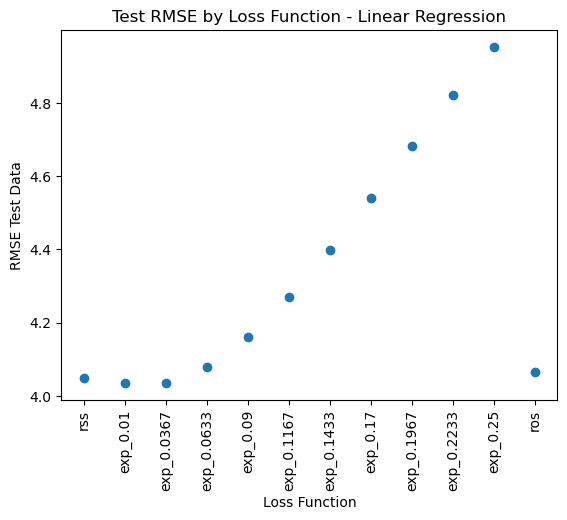

In [15]:
plt.scatter(df1.index, df1["lm"])
plt.xlabel('Loss Function')
plt.ylabel('RMSE Test Data')
plt.xticks(rotation=90)
plt.title('Test RMSE by Loss Function - Linear Regression')

<function matplotlib.pyplot.show(close=None, block=None)>

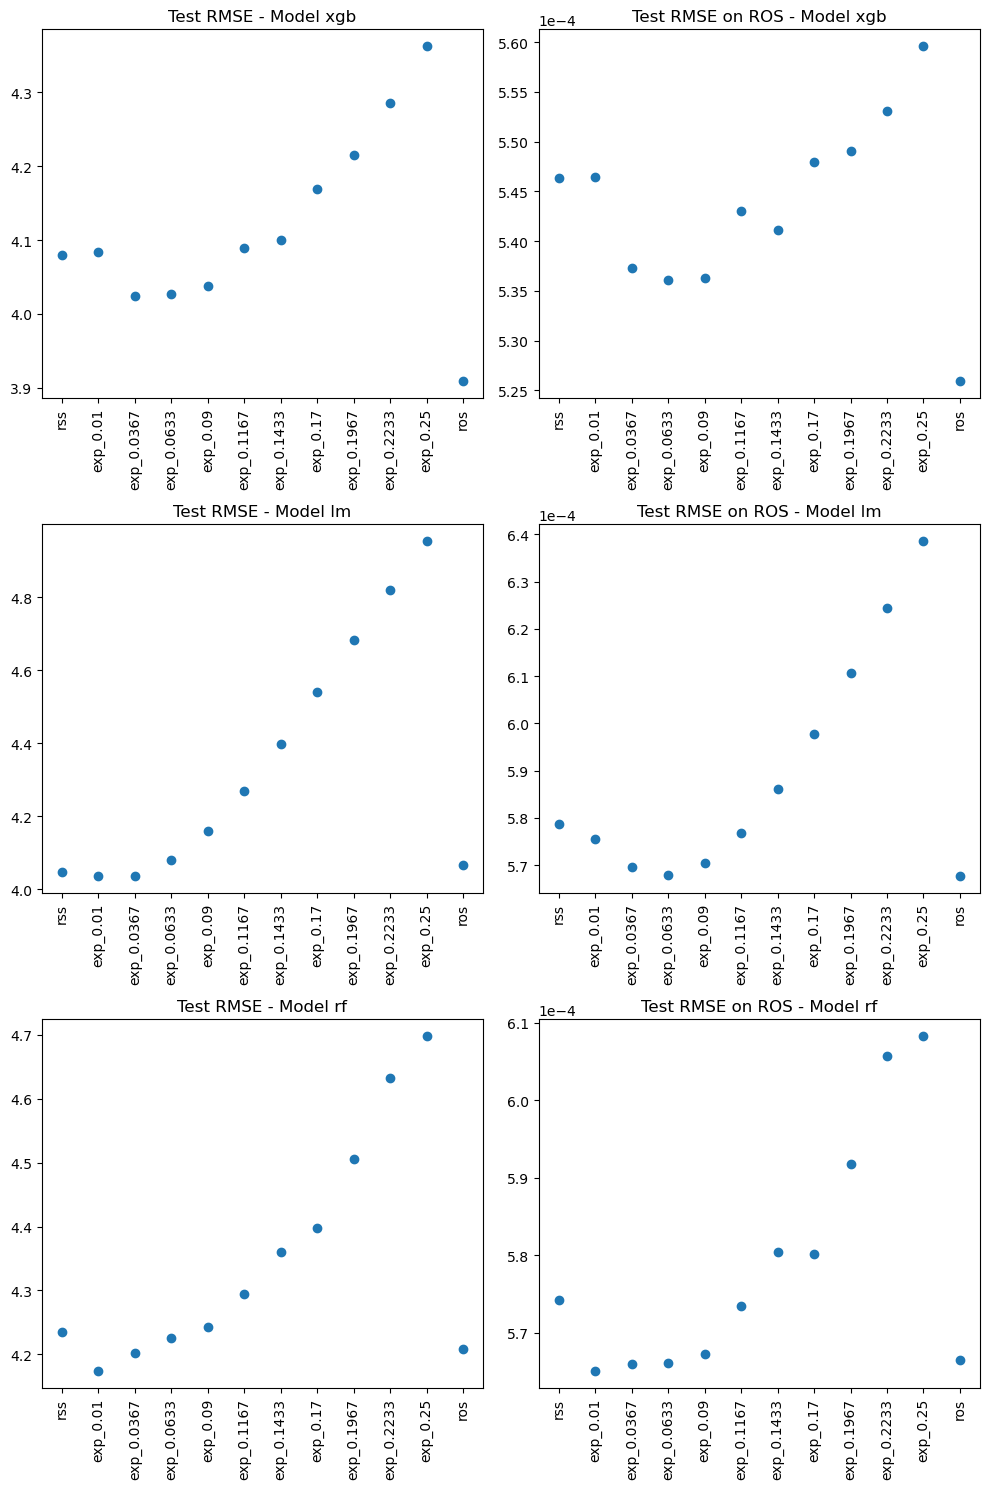

In [16]:
N = len(models_vec) # number of rows of subplots
fig, axes = plt.subplots(N, 2, figsize=(10, 5*N))
for i in range(0, len(models_vec)):
    mod = models_vec[i]
    # Access the subplot at row i, column 0
    ax1 = axes[i, 0]
    ax1.scatter(df1.index, df1[mod])
    ax1.tick_params(axis='x', rotation=90)
    ax1.set_title(f'Test RMSE - Model {mod}')

    # Access the subplot at row i, column 1
    ax2 = axes[i, 1]
    ax2.scatter(df2.index, df2[mod])
    ax2.tick_params(axis='x', rotation=90)
    ax2.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    ax2.set_title(f'Test RMSE on ROS - Model {mod}')

plt.tight_layout()
plt.show